## Module imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from scipy.stats import median_abs_deviation
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.time import Time
from tqdm import tqdm
%matplotlib inline

In [4]:
cd ..

/Users/azib/Documents/PhD/Exocomets/automated_exocomet_hunt


### SPOcc files

In [5]:
import data 
import loaders

In [9]:
cd automated_exocomet_hunt/

/Users/azib/Documents/PhD/Exocomets/automated_exocomet_hunt


In [10]:
def import_XRPlightcurve(file_path):
    """
    Importing the compressed TESS lightcurves from the XRP group.
    file_path: path to file
    :type file_path: pkl
    :returns: 
        - lc - lightcurve data as a DataFrame. 
        - store - Storage of other information (TIC, RA, Dec, TESS magnitude, Camera, Chip)
    """
    data = pd.read_pickle(file_path)

    ## extracting the lightcurve data and converting to Series from lists
    for i in range(len(data)):
        if isinstance(data[i],np.ndarray):
            data[i] = pd.Series(data[i])
    for_df = data[6:] # data[0:6] is not relevant in this case.
    columns = ['time','raw flux','corrected flux','PCA flux','flux error','quality']
    df = pd.DataFrame(data=for_df).T
    df.columns = columns
    return df, data[0:6]

def normalise_lc(flux):
    return flux/flux.mean()

In [15]:
lc, store = import_XRPlightcurve('tess/tesslcs_sector_14_104_2_min_cadence_targets_tesslc_122519163.pkl')
lc['normalised PCA'] = normalise_lc(lc['PCA flux'])

### First lightcurve

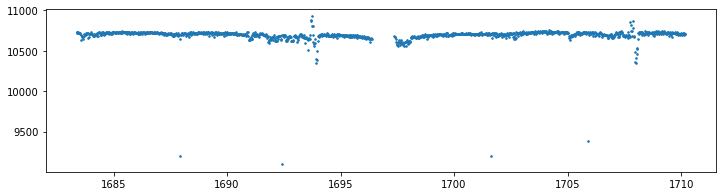

In [16]:
plt.figure(figsize=(12,3))
#lc['normalised PCA'][lc.quality==0].plot()
plt.scatter(lc['time'],lc['raw flux'],s=2.5)
#plt.ylim(340000,355000)
plt.show()

#### Reading in bad times data and target data.

In [17]:
bad_times = data.load_bad_times()
bad_times = bad_times - 2457000
mad_df = data.load_mad()

In [18]:
sec = 14
cam = store[4]
mad_arr = mad_df.loc[:len(lc)-1, f"{sec}-{cam}"]

In [19]:
np.count_nonzero(np.isnan(mad_arr))

255

### Testing MAD Thresholds

In [20]:
np.nanmedian(mad_arr)

0.0015885235999999999

In [38]:
np.std(mad_arr[900:950])

0.00013317909363043262

**Taking the MAD of `mad_arr`**

In [22]:
3*(1.48*median_abs_deviation(mad_arr,nan_policy='omit'))

0.0019870889219999995

**Sigma Clipping**

In [45]:
sig_clip = sigma_clip(mad_arr,sigma=3,masked=False)
med_sig_clip = np.nanmedian(sig_clip)
med_sig_clip

0.00148086695

**RMS of Sigma Clipping**

In [46]:
rms_sig_clip = np.sqrt(np.mean((sig_clip-med_sig_clip)**2))
rms_sig_clip 

0.0005645222361301955

In [47]:
np.std(sig_clip)

0.0005338896740044282

### MAD plots

For each Sector-Camera combination, any cadences above a threshold are flagged. The threshold is defined as 10 times the standard deviation of MAD values for a quiet portion of the plot, visually identified as cadences 900 to 950, plus the median MAD value of the quiet section. The 10-sigma threshold was determined visually to preserve most data while culling the most problematic sections.

$$\text{threshold} = \texttt{med}(\text{MAD}_{quiet})+ 10*\sigma_{quiet}$$



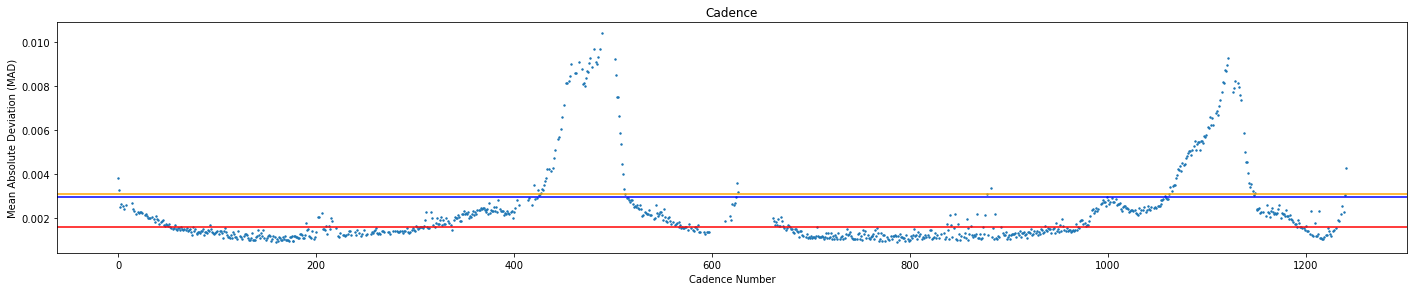

In [56]:
fig,ax = plt.subplots(1,figsize=(10,4))
# ax1.scatter(lc.time, mad_arr, s=2)
# 
# #ax1.axhline(med_sig_clip, c='r',linestyle='--')
# ax1.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[700:800]),c='blue') # 10 sigma threshold
# 
# #ax1.axhline(np.nanmedian(mad_arr)+3*(1.48*median_abs_deviation(mad_arr,nan_policy='omit')),c='blue')
# #ax1.axhline(np.nanmedian(mad_arr)+(med_sig_clip),c='blue')
# #ax1.axhline(np.nanmedian(mad_arr)+(rms_sig_clip),c='orange')

ax.scatter(range(0,len(lc.time)), mad_arr, s=2)
ax.axhline(np.nanmedian(mad_arr), c='r')
ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[700:800]),c='blue') # 10 sigma threshold
ax.axhline(med_sig_clip + 3*(np.std(sig_clip)), c='orange')




ax.set_xlabel('Cadence Number')
ax.set_ylabel('Mean Absolute Deviation (MAD)')
ax.set_title('Cadence')
plt.subplots_adjust(bottom=0.1, right=2.0, top=0.9)
plt.show()

#### Test: Percentile plot

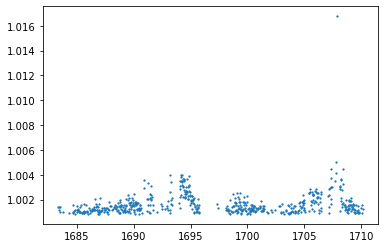

In [17]:
quality_data = lc.loc[lc['quality']==0]
normalised = quality_data[['time','normalised PCA']]
q75, q25 = np.percentile(normalised, [75,25])
iqr = q75 - q25
test = normalised.loc[(q25 <= normalised['normalised PCA']) & (normalised['normalised PCA'] <= q75)]
plt.scatter(test['time'],test['normalised PCA'],s=1.5)
plt.show()

---

Note: higher `mad_arr`, higher deviation/error. Hence cutoff with `mad_cut`:

In [18]:
mad_cut = mad_arr.values<(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950])) # removes any values above threshold

Creating the `bad_times` mask

In [19]:
mask = np.ones_like(lc.time, dtype=bool)
for i in bad_times:
    newchunk = (lc.time<i[0])|(lc.time>i[1])
    mask = mask & newchunk

### Comparison of plots (`quality = 0`)

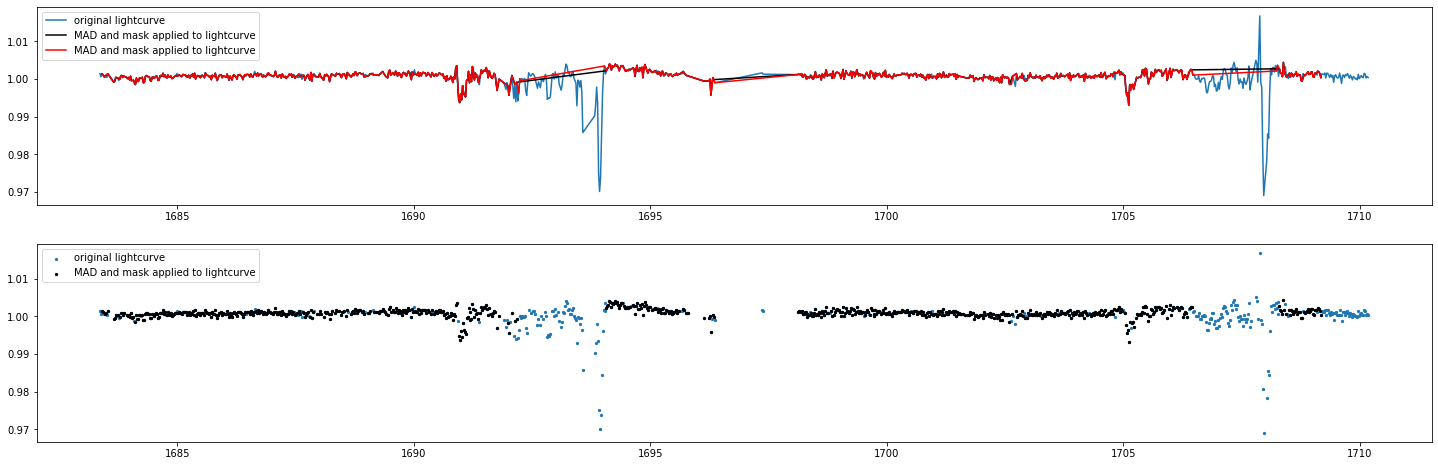

In [20]:
fig,ax = plt.subplots(2,figsize=(25,8))

ax[0].plot(lc['time'][lc.quality==0],lc['normalised PCA'][lc.quality==0],label='original lightcurve')
ax[0].plot(lc['time'][(lc.quality==0) & mask & mad_cut],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut],c='black',label='MAD and mask applied to lightcurve')
ax[1].scatter(lc['time'][lc.quality==0],lc['normalised PCA'][lc.quality==0],label='original lightcurve',s=5)
ax[1].scatter(lc['time'][(lc.quality==0) & mask & mad_cut],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut],c='black',label='MAD and mask applied to lightcurve',s=5)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
#plt.ylim(0.9975,1.005)
plt.show()

### Notes:

- The task is to mask the bad quality data in the lightcurves even when the quality flags are set to zero `lc.quality=0`.
- To do so, we use Ethan Kruse's masks, which provide the "bad times" in each sector and we adjust the offset accordingly. These bad times represent an excess of false transits.
- We then use the Median Absolute Deviation (MAD), given by: 
    
    $$\text{MAD}(t)=\texttt{median}(\{|F_{lc}(t)-\bar{F_t}|\text{ }|\text{ }lc\in \text{SCD}\})$$
    
- The MAD is used to identify offending cadences, and it is computed for each cadence by Sector/Camera/Detector (SCD). The MAD at a cadence centered at a time, t, for a given set of light curves in a (SCD) is the median value of the set of absolute value deviations from the median flux at that time.


In [21]:
lc.min()

time              1683.367944
raw flux          9096.448600
corrected flux    9130.838317
PCA flux          9113.955288
flux error           2.825011
quality              0.000000
normalised PCA       0.851804
dtype: float64

In [22]:
lc[lc['time'] == 1468.283349]
lc = lc[lc > 1]

---

### Comparison of plots (no flags filtered)

[]

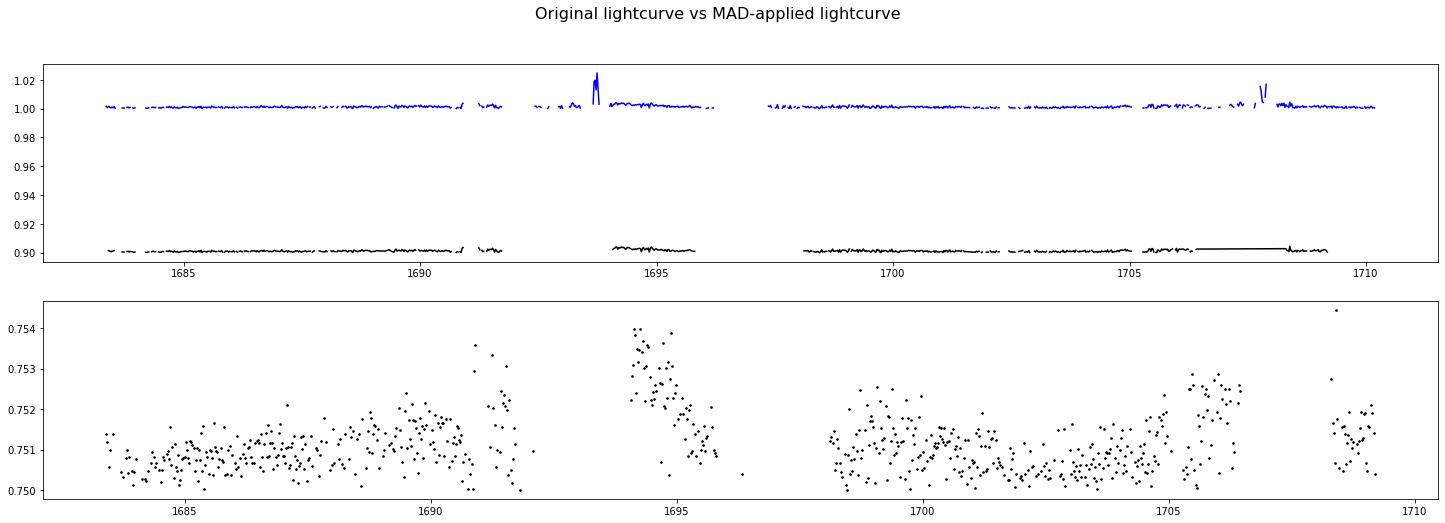

In [23]:
fig,ax2 = plt.subplots(2,figsize=(25,8))
fig.suptitle('Original lightcurve vs MAD-applied lightcurve',fontsize=16)
ax2[0].plot(lc['time'][(lc.quality==0) | (lc.quality!=0)],lc['normalised PCA'][(lc.quality==0) | (lc.quality!=0)],c='blue')
ax2[0].plot(lc['time'][((lc.quality==0) | (lc.quality!=0)) & mask & mad_cut],lc['normalised PCA'][((lc.quality==0) | (lc.quality!=0)) & mask & mad_cut]-0.1,c='black')
#ax2[1].scatter(lc['time'][(lc.quality==0) | (lc.quality!=0)],lc['normalised PCA'][(lc.quality==0) | (lc.quality!=0)],c='blue',s=2.5)
ax2[1].scatter(lc['time'][((lc.quality==0) | (lc.quality!=0)) & mask & mad_cut],lc['normalised PCA'][((lc.quality==0) | (lc.quality!=0)) & mask & mad_cut]-0.25,c='black',s=2.5)
plt.plot()

### Plot of original lightcurve and the lightcurve with `quality=0`

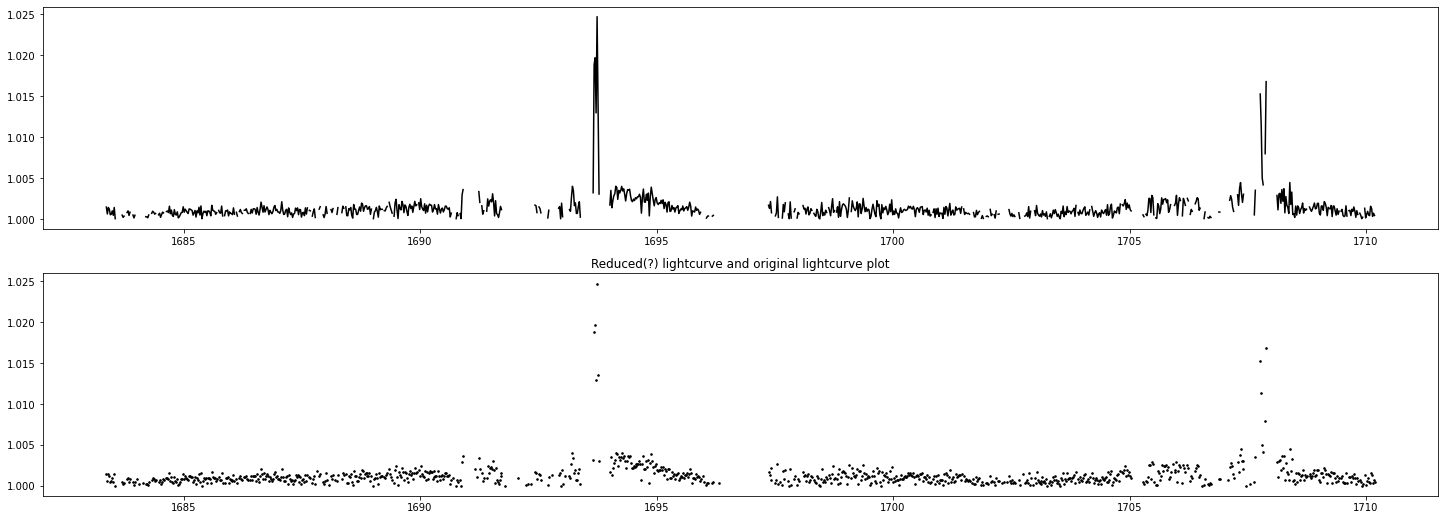

In [24]:
fig,ax1 = plt.subplots(2, figsize=(25,9))
plt.title('Reduced(?) lightcurve and original lightcurve plot')


ax1[0].plot(lc['time'],lc['normalised PCA'],c='black')
ax1[0].plot(lc['time'][(lc.quality==0)],lc['normalised PCA'][(lc.quality==0)],c='orange')
ax1[1].scatter(lc['time'],lc['normalised PCA'],c='black',s=2.5)
ax1[1].scatter(lc['time'][(lc.quality==0)],lc['normalised PCA'][(lc.quality==0)],c='orange',s=2.5)
#lc['normalised PCA'].plot(ax=ax1,label='original lightcurve')
#(lc['normalised PCA'][(lc.quality==0) & mask & mad_cut]).plot(ax=ax1,c='orange',label='quality=0 lightcurve')
#ax1.legend(loc=2,fontsize='medium')
plt.show()

We can see here that the reduced lightcurve does a good job in removing the noise without needing to refer to the quality flags. 
- But, we should check what flags are worth removing and what are worth keeping in the data.

---

/Users/azib/opt/anaconda3/envs/spocc/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/azib/opt/anaconda3/envs/spocc/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/azib/opt/anaconda3/envs/spocc/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


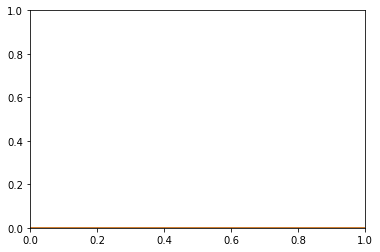

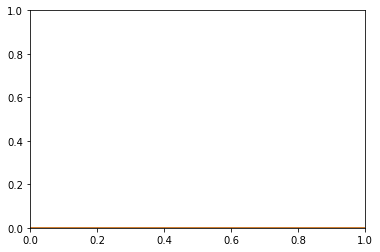

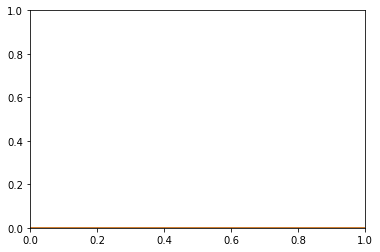

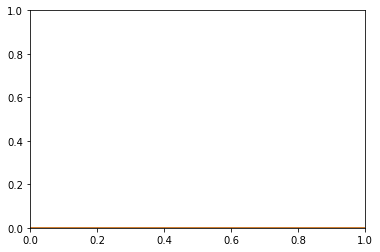

AttributeError: 'numpy.ndarray' object has no attribute 'axhline'

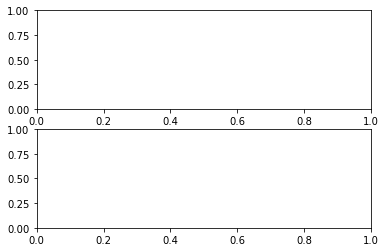

In [94]:
sectors = np.arange(1,27,1)
cam = [1,2,3,4]
mad_arr = []
sig_clip = []
np.std(sig_clip)
for i in sectors:
    for j in cam:
        mad_arr = mad_df.loc[:len(lc)-1, f"{i}-{j}"]
        sig_clip = sigma_clip(mad_arr,sigma=3,masked=False)  
        med_sig_clip = np.nanmedian(sig_clip)
        rms_sig_clip = np.sqrt(np.mean((sig_clip-med_sig_clip)**2))
        fig,ax = plt.subplots(i)
        ax.scatter(range(0,len(lc.time)), mad_arr, s=2)
        ax.axhline(np.nanmedian(mad_arr), c='r')
        ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue') # 10 sigma threshold
        ax.axhline(med_sig_clip + 3*(np.std(sig_clip)), c='orange')
        plt.show()

In [63]:
mad_arr = mad_df.loc[:len(lc)-1, f"{sec}-{cam}"]

KeyError: '14-[1, 2, 3, 4]'

In [72]:
mad_df.columns

Index(['1-1', '1-2', '1-3', '1-4', '2-1', '2-2', '2-3', '2-4', '3-1', '3-2',
       ...
       '24-3', '24-4', '25-1', '25-2', '25-3', '25-4', '26-1', '26-2', '26-3',
       '26-4'],
      dtype='object', length=104)